In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, utils
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
import random

device = torch.device("cpu")

In [2]:
# --------------------
# Data Preparation
# --------------------
# Define image transformations
transform = transforms.Compose([
    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # Normalize to [-1, 1]
])


In [ ]:
#this is for 128 images but it takes to long and the results are not really worth unless ypu crank the epochs to 300 but that would take
# more than 4 hours of train time and i dont really have that
#remove 128 from name to use it
transform128 = transforms.Compose([
    transforms.Resize(128),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # Normalize to [-1, 1]
])

In [ ]:
#remove the 128 from the calss name to use
class Discriminator128(nn.Module):
    def __init__(self, img_channels=3):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(img_channels, 32, 4, 2, 1, bias=False),          # 128x128 -> 64x64
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(32, 64, 4, 2, 1, bias=False),                    # 64x64 -> 32x32
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),                   # 32x32 -> 16x16
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),                  # 16x16 -> 8x8
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),                  # 8x8 -> 4x4
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),                    # 4x4 -> 1x1
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x).view(-1, 1).squeeze(1)

In [ ]:
#remove 128 from the name to use it
import torch.nn as nn

class Generator128(nn.Module):
    def __init__(self, latent_dim=100, img_channels=3):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 512, 4, 1, 0, bias=False),  # 1x1 -> 4x4
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),         # 4x4 -> 8x8
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),         # 8x8 -> 16x16
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),          # 16x16 -> 32x32
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, 4, 2, 1, bias=False),           # 32x32 -> 64x64
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, img_channels, 4, 2, 1, bias=False), # 64x64 -> 128x128
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)

In [33]:
# you need to wait fo rall of them to be loaded otherwise it just leads to errors
# Load images from dog and cat folders
dataset = datasets.ImageFolder(
    root='archive/PetImages/',  # Path to the dataset folder
    transform=transform
)

# Print the class-to-label mapping
print(dataset.class_to_idx)

# this takes a while because it loads all 12k images so it can create a random subset afterwards
# you could change it to just load always the first x y images but that could lead to problems 
# because it always the same images. The model should be trained on random images to make sure it can generalize and not be overtrained
# on the same dataset, especially if the epoch becomes higher than 100

# Get indices for each class (dog=0, cat=1)
dog_indices = [i for i, (_, label) in enumerate(dataset) if label == 1]
cat_indices = [i for i, (_, label) in enumerate(dataset) if label == 0]

print("loaded all Indices")

# Define the exact number of images
# 5k:5k for 1:1 10:10
# 5k:2.5k for 2:1 10:5
# 5k:500 for 10:1
# 5k:3.5k for 10:7
num_dog_images = 2000
num_cat_images = 1000

# Randomly select the specified number of images
selected_dog_indices = random.sample(dog_indices, num_dog_images)
selected_cat_indices = random.sample(cat_indices, num_cat_images)

print("sampled Indeces")

# Combine and shuffle the selected indices
selected_indices = selected_dog_indices + selected_cat_indices
random.shuffle(selected_indices)

# Create the subset dataset
subset_dataset = Subset(dataset, selected_indices)

# DataLoader
batch_size = 64
dataloader = DataLoader(subset_dataset, batch_size=batch_size, shuffle=True)

# Verify the dataset sizes
print(f"Number of selected images: {len(subset_dataset)}")

{'Cat': 0, 'Dog': 1}
loaded all Indices
sampled Indeces
Number of selected images: 3000


In [34]:
# --------------------
# GAN Architecture
# --------------------
# Generator
class Generator(nn.Module):
    def __init__(self, latent_dim=100, img_channels=3):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, img_channels, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)


In [35]:
# Discriminator
class Discriminator(nn.Module):
    def __init__(self, img_channels=3):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(img_channels, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x).view(-1, 1).squeeze(1)

In [36]:
# Instantiate models
latent_dim = 150
generator = Generator(latent_dim).to(device)
discriminator = Discriminator().to(device)

# Loss and optimizers
criterion = nn.BCELoss()
optimizer_g = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_d = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))


In [37]:
# --------------------
# Training Loop
# --------------------
epochs = 100
for epoch in range(epochs):
    for i, (real_images, _) in enumerate(dataloader):
        # Prepare data
        real_images = real_images.to(device)
        batch_size = real_images.size(0)

        # Create labels
        real_labels = torch.ones(batch_size, device=device)
        fake_labels = torch.zeros(batch_size, device=device)

        # Train Discriminator
        noise = torch.randn(batch_size, latent_dim, 1, 1, device=device)
        fake_images = generator(noise)
        real_loss = criterion(discriminator(real_images), real_labels)
        fake_loss = criterion(discriminator(fake_images.detach()), fake_labels)
        d_loss = real_loss + fake_loss
        optimizer_d.zero_grad()
        d_loss.backward()
        optimizer_d.step()

        # Train Generator
        noise = torch.randn(batch_size, latent_dim, 1, 1, device=device)
        fake_images = generator(noise)
        g_loss = criterion(discriminator(fake_images), real_labels)
        optimizer_g.zero_grad()
        g_loss.backward()
        optimizer_g.step()

    print(f"Epoch [{epoch+1}/{epochs}] | D Loss: {d_loss.item():.4f} | G Loss: {g_loss.item():.4f}")


Epoch [1/100] | D Loss: 2.2226 | G Loss: 12.6239
Epoch [2/100] | D Loss: 0.2262 | G Loss: 3.4189
Epoch [3/100] | D Loss: 0.6331 | G Loss: 2.3341
Epoch [4/100] | D Loss: 0.2439 | G Loss: 3.1630
Epoch [5/100] | D Loss: 0.4090 | G Loss: 3.0519
Epoch [6/100] | D Loss: 0.5282 | G Loss: 4.8346
Epoch [7/100] | D Loss: 0.3348 | G Loss: 2.9202
Epoch [8/100] | D Loss: 0.7303 | G Loss: 5.1949
Epoch [9/100] | D Loss: 0.6460 | G Loss: 2.4402
Epoch [10/100] | D Loss: 0.8173 | G Loss: 4.3734
Epoch [11/100] | D Loss: 0.4453 | G Loss: 4.4070
Epoch [12/100] | D Loss: 0.6790 | G Loss: 4.7847
Epoch [13/100] | D Loss: 0.2739 | G Loss: 3.9727
Epoch [14/100] | D Loss: 0.5377 | G Loss: 2.8748
Epoch [15/100] | D Loss: 0.3152 | G Loss: 4.4678
Epoch [16/100] | D Loss: 0.2458 | G Loss: 4.4970
Epoch [17/100] | D Loss: 0.2561 | G Loss: 3.7491
Epoch [18/100] | D Loss: 0.9495 | G Loss: 6.2824
Epoch [19/100] | D Loss: 0.8711 | G Loss: 3.8968
Epoch [20/100] | D Loss: 0.6635 | G Loss: 3.3973
Epoch [21/100] | D Loss: 0.5

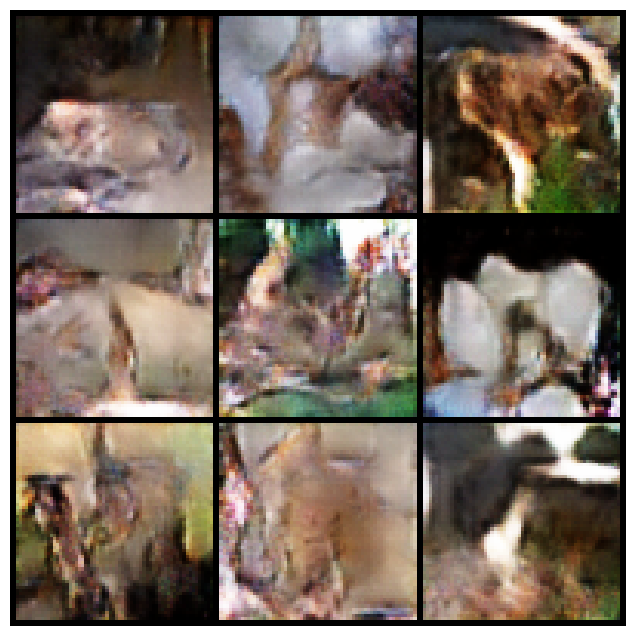

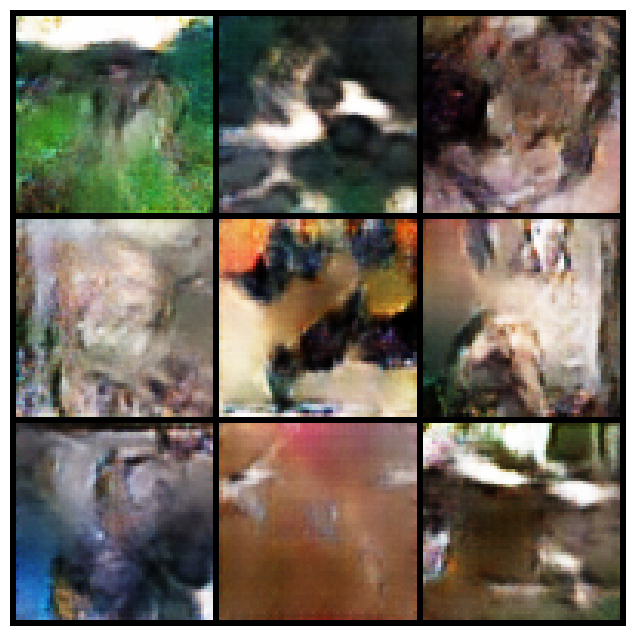

In [79]:
# --------------------
# Generate Images
# --------------------
def generate_images(generator, latent_dim, num_images=9):
    generator.eval()
    with torch.no_grad():
        noise = torch.randn(num_images, latent_dim, 1, 1, device=device)
        fake_images = generator(noise).cpu()
    return fake_images

# Generate and display 3x3 grid of images or 5x6 to get more iamges
generated_images = generate_images(generator, latent_dim, 9)
grid = utils.make_grid(generated_images, nrow=3, normalize=True)
plt.figure(figsize=(8, 8))
plt.imshow(grid.permute(1, 2, 0))
plt.axis('off')
plt.show()
generated_images = generate_images(generator, latent_dim, 9)
grid = utils.make_grid(generated_images, nrow=3, normalize=True)
plt.figure(figsize=(8, 8))
plt.imshow(grid.permute(1, 2, 0))
plt.axis('off')
plt.show()

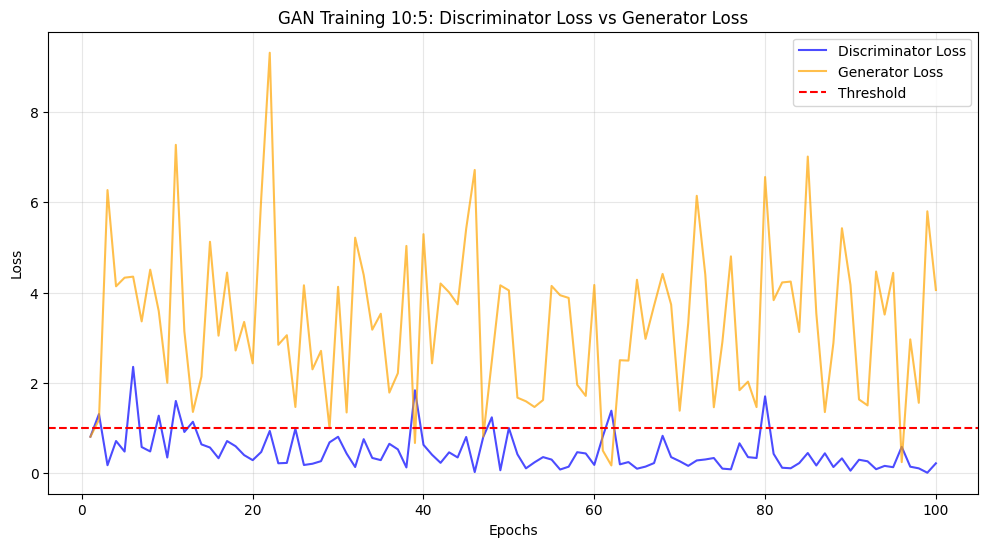

In [16]:
import matplotlib.pyplot as plt



# Extracting Epochs, D Loss, and G Loss from the provided data
# just copy paste the values from the print statements above for d loss and g loss 
epochs = list(range(1, 101))
d_loss = [
    0.8116,
1.3130,
0.1802,
0.7159,
0.4826,
2.3580,
0.5828,
0.4851,
1.2772,
0.3506,
1.6032,
0.9165,
1.1423,
0.6417,
0.5718,
0.3352,
0.7155,
0.6003,
0.4038,
0.2925,
0.4731,
0.9391,
0.2230,
0.2311,
0.9863,
0.1853,
0.2128,
0.2699,
0.6866,
0.8100,
0.4375,
0.1405,
0.7570,
0.3415,
0.2928,
0.6546,
0.5313,
0.1312,
1.8389,
0.6320,
0.4124,
0.2329,
0.4655,
0.3522,
0.8055,
0.0287,
0.8060,
1.2404,
0.0683,
1.0034,
0.4225,
0.1111,
0.2439,
0.3600,
0.3051,
0.0849,
0.1477,
0.4685,
0.4405,
0.1874,
0.8176,
1.3874,
0.1997,
0.2499,
0.1029,
0.1495,
0.2281,
0.8316,
0.3593,
0.2688,
0.1660,
0.2862,
0.3076,
0.3398,
0.1047,
0.0895,
0.6649,
0.3592,
0.3402,
1.7046,
0.4325,
0.1244,
0.1127,
0.2278,
0.4508,
0.1747,
0.4439,
0.1399,
0.3321,
0.0600,
0.3016,
0.2671,
0.0921,
0.1654,
0.1365,
0.5876,
0.1478,
0.1108,
0.0141,
0.2220,
]

g_loss = [
    0.8111,
1.1860,
6.2721,
4.1414,
4.3323,
4.3555,
3.3642,
4.5099,
3.5929,
2.0062,
7.2738,
3.1454,
1.3594,
2.1414,
5.1274,
3.0488,
4.4447,
2.7201,
3.3532,
2.4364,
6.0906,
9.3131,
2.8466,
3.0587,
1.4695,
4.1639,
2.3028,
2.7122,
0.9986,
4.1307,
1.3481,
5.2179,
4.3933,
3.1808,
3.5345,
1.7880,
2.2180,
5.0359,
0.6722,
5.2959,
2.4365,
4.2039,
4.0082,
3.7425,
5.4162,
6.7173,
0.8134,
2.4821,
4.1635,
4.0500,
1.6761,
1.5953,
1.4693,
1.6231,
4.1499,
3.9441,
3.8843,
1.9611,
1.7148,
4.1710,
0.5041,
0.1752,
2.5048,
2.4966,
4.2863,
2.9775,
3.7132,
4.4161,
3.7366,
1.3872,
3.3233,
6.1453,
4.3981,
1.4639,
2.9091,
4.8043,
1.8409,
2.0311,
1.4668,
6.5608,
3.8345,
4.2267,
4.2465,
3.1302,
7.0141,
3.5394,
1.3568,
2.8837,
5.4273,
4.1713,
1.6364,
1.5044,
4.4685,
3.5153,
4.4391,
0.2486,
2.9664,
1.5615,
5.8022,
4.0593,
]




# Plotting the graph

plt.figure(figsize=(12, 6))

plt.plot(epochs, d_loss, label="Discriminator Loss", color="blue", alpha=0.7)

plt.plot(epochs, g_loss, label="Generator Loss", color="orange", alpha=0.7)

plt.axhline(1, color='red', linestyle='--', label='Threshold')

plt.xlabel("Epochs")

plt.ylabel("Loss")

plt.title("GAN Training 10:5: Discriminator Loss vs Generator Loss")

plt.legend()

plt.grid(alpha=0.3)

plt.show()